# KNN & Semantic Search

K-Nearest Neighbors (KNN) is a simple, intuitive way to predict an outcome by looking at the most similar examples in your dataset.

**What Makes Things Similar?**

By "similar," we look at the features of each item in your dataset and measure how close they are in feature space — just like comparing people by their height, weight, or age. The nearer two points are, the more alike they are presumed to be.

Searching for something similar is a key concept in many information retrieval systems, recommendation engines, synonyms searching, etc.

**Dimensions are Implicit Features**

So how do we measure the distance between two items with multiple features? Well, we use a distance metric (duh!) like cosine, euclidean, or dot product (more on this later). 

In all cases, the simple steps are:
1. Represent each item as a vector i.e. an ordered list of numbers - one number per feature/dimension
2. Place each vector in a shared space i.e. each feature is one axis within a high-dimension space, with your vector number appearing on that axis
3. Compute the distance between a vector and your vector of interest using Cosine, Euclidean, Dot product

Each dimension represents one axis of MANY in a high-dimensional space.
You can imagine every data point as a star in a vast semantic galaxy, where its coordinates define its place in the universe. Stars that lie close together share similar features 

### Libraries

In [43]:
# Data Analytics
import pandas as pd
import numpy as np

# Data Collection
import requests
from bs4 import BeautifulSoup
#Data Preparation
from sklearn.preprocessing import StandardScaler
# Data Extraction
import re

# Data Visualisation
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

# Models
from sklearn.neighbors import KNeighborsClassifier
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sentence_transformers import SentenceTransformer

#Utils
import time

### Simple KNN Example: Friend Groups at school

Imagine a class with 30 kids where 6 friend groups have been established. All we know about each kid is their height and weight. 

If a new kid joins the class, what 5 children will they be most similar to? What friend group might they join?

**GoldilocKs and the three bears**
- keep k odd --> prevent voting ties (remember 3 bears is odd!)
- Not too low (1-3) --> sensitive to noise
- Not too high (9+) --> can lose local structure

In [33]:
data = {
    'height': [125, 129, 128, 135, 129, 139, 145, 140, 136, 147, 165, 159, 156, 153, 152, 162, 165, 164, 167, 163, 145, 143, 144, 145, 144, 176, 174, 175, 177, 169],
    'weight': [35, 38, 34, 41, 28, 37, 43, 41, 39, 41, 45, 55, 54, 51, 57, 61, 65, 62, 69, 63, 43, 48, 50, 53, 49, 75, 74, 65, 77, 68],
    'group': ['Group 0','Group 0','Group 0','Group 0','Group 0','Group 1','Group 1','Group 1','Group 1','Group 1', 'Group 2','Group 2','Group 2','Group 2','Group 2','Group 3','Group 3','Group 3','Group 3','Group 3','Group 4','Group 4','Group 4','Group 4','Group 4', 'Group 5','Group 5','Group 5','Group 5','Group 5']
}

df = pd.DataFrame(data)

### Scale Data

In [34]:
scaler = StandardScaler()

X = df[['height', 'weight']].values.astype(float)
X_scaled = scaler.fit_transform(X)

df['y'] = df['group'].str.extract(r'(\d+)').astype(int)
y = df['y'].values


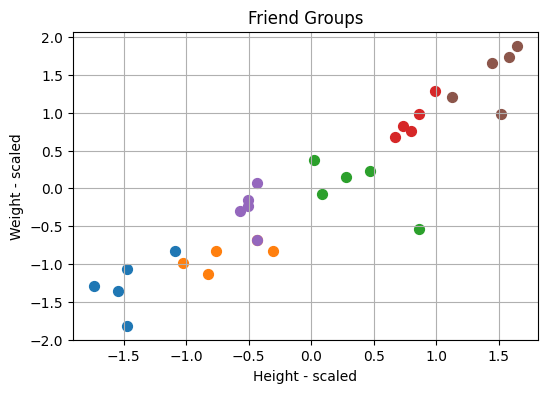

In [ ]:
y_groups = df['group'].values

plt.figure(figsize=(6, 4))
group_names = df['group'].unique().tolist()

for group in group_names:
    mask = y_groups == group
    plt.scatter(X_scaled[mask, 0], X_scaled[mask, 1], label=f"{group}", s=50)

plt.xlabel("Height - scaled")
plt.ylabel("Weight - scaled")
plt.title("Friend Groups")
#plt.legend()
plt.grid(True)
plt.show()


### Recommendation: visualising Decision Regions and nearest neighbors

For low-dimensional classification tasks like our example, we can use tools such as mlxtend to visualise the decision regions and develop an intuition for how KNN separates different groups in the feature space.

/Users/tobygardner/Projects/uc-berkeley-aiml-course/.venv/lib/python3.12/site-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


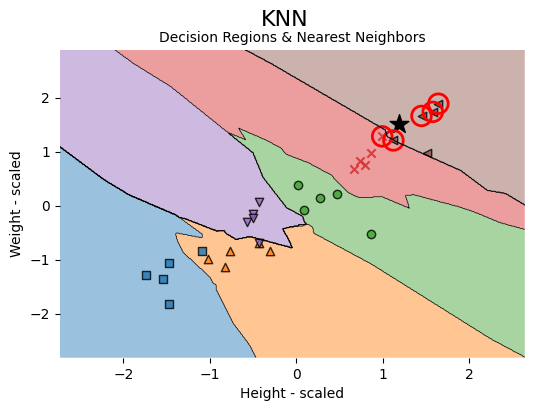

In [ ]:
# New kid of height 170, weight 72
new_kid = np.array([[170, 72]])

# TIP Use transform, NOT fit_transform to use the same scaler as X
new_kid_scaled = scaler.transform(new_kid)

k = 5

# Fit Model
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_scaled, y)

plt.figure(figsize=(6, 4))

# Highlight Decision Regions, New Kid, 5 Nearest Neighbors
plot_decision_regions(X=X_scaled, y=y, clf=knn, legend=0)
plt.scatter(new_kid_scaled[0,0], new_kid_scaled[0,1], color="black", s=200, marker="*", label="New Kid")
neighbors = knn.kneighbors(new_kid_scaled, return_distance=False)

#Plot
nn_idx = neighbors[0]
plt.scatter(X_scaled[nn_idx, 0], X_scaled[nn_idx, 1],facecolors='none', edgecolors='red', s=200, linewidths=2,label='Nearest Neighbors')

plt.xlabel("Height - scaled"); plt.ylabel("Weight - scaled"); plt.suptitle("KNN", fontsize=16); plt.title("Decision Regions & Nearest Neighbors", fontsize=10); 

plt.show()


One thing you'll notice is what happens when data points (vectors) fall near the boundaries between regions: the nearest neighbour may easily belong to a different class. In other words, points sitting on or close to a decision boundary are inherently unstable—small changes in position or noise can flip their predicted label.

Does this remind you of an issue we discussed in unsupervised learning?
Exactly — Clustering!

## Semantic Search using KNN

In our simple example, we compared the new kid's vector to all existing kids' vectors and identified 5 (k) kids that were most similar—i.e., their vectors had the shortest distance to the new kid's.

This is essentially what semantic search is, and it's becoming foundational in companies using GenAI at work.


### Real-World Application: Information Retrieval (RAG Pipelines)

Let's take an article from last week from the University of California Athletics Department - announcing the hiring of Tosh Lupoi as new Football Head Coach. 

We'll use this article to create a high-dimensional space of vectors, with each vector representing a sentence from the article. 

In order to do it we will:
1. Data Collection - pull article from a webpage
2. Data Preparation - split article into sentences
3. Feature Engineering (article) - encode each sentence (via tokenisation) and create a high-dimensional vector using an Embedding Model
4. Create a Test (query)
5. Feature Engineering (query) - encode the query using the same process as above
6. Run Model (KNN) - using Cosine, Euclidean, Dot Product
7. Evaluate Results - identify sentences containing the correct answer and score

Note: Instead of just 2 dimensions (height and weight), we're now working with 384 dimensions that capture the semantic meaning of text. Same principle, just more axes in our coordinate system!

### Data Collection

In [ ]:
url = "https://calbears.com/news/2025/12/4/tosh-lupoi-named-travers-family-head-football-coach.aspx"

headers = {
    "User-Agent": (
        "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/120.0.0.0 Safari/537.36"
    )
}

response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, "html.parser")

### Data Preparation

In [ ]:
article_body = soup.find('div', class_='article__content')
paragraphs = article_body.find_all('p') if article_body else []

# Combine all paragraph text
text = ' '.join([p.get_text(strip=True) for p in paragraphs])

sentences = re.split(r'(?<=[.!?])\s+', text)
sentences = [s.strip() for s in sentences if s.strip()]

df = pd.DataFrame({'id': range(1, len(sentences) + 1),'sentence': sentences})


### Feature Engineering (Embedding Model)

**Painful lesson - read Model Cards**
As a painful lesson, remember to always check model cards and what they support. For instance, Cosine is so common in embedding models that its often built-in as a normalisation layer/module prior to outputting the embedding vectors. 

I wasted a lot of time trying to debug what in my code was causing Euclidean and Dot distances to be the same as Cosine! 

In [ ]:
model_name = "sentence-transformers/all-MiniLM-L6-v2"

def load_embedding_model(model_name):

    model = SentenceTransformer(model_name)
    
    modules = list(model._modules.keys())
    for key in modules:
        if model._modules[key].__class__.__name__ == "Normalize":
            del model._modules[key]
            print(f"[INFO] Removed Normalize() layer from module {key}")

    return model


#### Distance Metrics: use in Gen-AI applications

When working with high-dimensional vectors like our 384-dimension text embeddings, choosing the right distance metric becomes crucial. Let's understand what to expect from each one and why.

**Euclidean Distance: straight line**
Euclidean distance works great for low dimensions (like height and weight), but in high-dimensional spaces, it can become less meaningful. As dimensions increase, all points tend to become roughly equal distance from each other aka "curse of dimensionality."

**Cosine Similarity: Information Retrieval (Embedding Models)**
Think of it like comparing proportions rather than absolute values e.g. a tall, heavy student might be relatively proportionate to a short, light student over these two-dimensions. As their height: weight ratios align, so too will their vectors point in the same direction, giving a cosine of ~ 1

This makes cosine great for embedding models as it measures only the angle (semantic alignment)

**Dot Product: (LLM Transformer Blocks - Attention Layers)**
Dot product combines both the angle between vectors and their magnitudes. It’s like cosine similarity but without *normalizing* the vectors first. 

Why? Because we use the magnitude of a dimension as a signal of strength...larger magnitude vectors indicate that this token (word/sub-word) is more important than others in this particular context window/passage etc. 

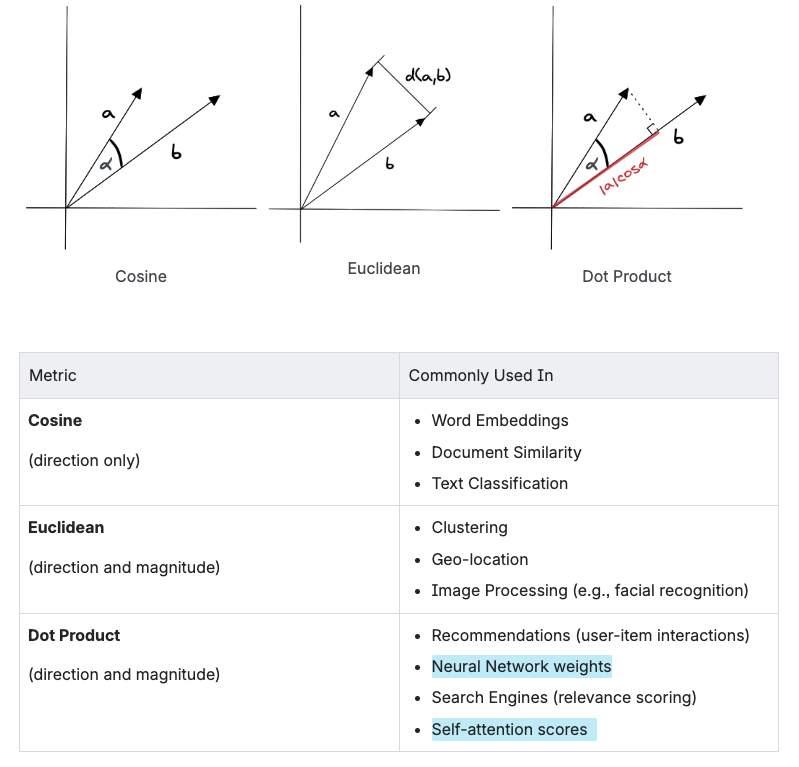

In [44]:
from IPython.display import Image, display

display(Image(filename="../images/distance_metrics.png"))

In [ ]:
def embed_chunks(df, model_name, metric="cosine", batch_size=16):

    embed_model = load_embedding_model(model_name)

    df = df.copy()

    sentences = df["sentence"].tolist()
    
    raw_embeddings = embed_model.encode(
        sentences,
        batch_size=batch_size,
        normalize_embeddings=False,
        show_progress_bar=True
    ).astype("float32")

    if metric == "cosine":
        norms = np.linalg.norm(raw_embeddings, axis=1, keepdims=True)
        embeddings = raw_embeddings / norms
        df[f"embedding_{metric}"] = list(embeddings)    
    else:
        embeddings = raw_embeddings
        df[f"embedding_{metric}"] = list(embeddings)

    return df

#### Embedding Vector (Save as parquet)
Why? 
- Parquet also keeps float32 vector embeddings intact
- Best to embed and store data source (article) once, unless you need to update the data source with new articles (in which case you need to create embeddings again)


In [272]:
vector_store_cos = embed_chunks(df, model_name, metric="cosine")
vector_store_dot = embed_chunks(df, model_name, metric="dot")
vector_store_eucl = embed_chunks(df, model_name, metric="euclidean")

vector_store_cos.to_parquet("../datasets/vector_store_cos.parquet")
vector_store_dot.to_parquet("../datasets/vector_store_dot.parquet")
vector_store_eucl.to_parquet("../datasets/vector_store_eucl.parquet")

[INFO] Removed Normalize() layer from module 2


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

[INFO] Removed Normalize() layer from module 2


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

[INFO] Removed Normalize() layer from module 2


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
df_cos = pd.read_parquet("../datasets/vector_store_cos.parquet")
df_dot = pd.read_parquet("../datasets/vector_store_dot.parquet")
df_eucl = pd.read_parquet("../datasets/vector_store_eucl.parquet")


### KNN Tests

In [6]:
df_cos.head()

,id,sentence,embedding_cosine
0,1,"Tosh Lupoi, a former California defensive line...","[-0.10448195, -0.043699443, -0.0299283, -0.009..."
1,2,Lupoi comes home to Berkeley to become the 35t...,"[0.02842539, -0.07558858, -0.0026184358, -0.02..."
2,3,He also won a pair of national championships d...,"[-0.052429713, -0.0010811836, -0.015264654, -0..."
3,4,Lupoi has additionally spent time on the coach...,"[-0.06439475, -0.011721408, -0.0007440311, -0...."
4,5,Lupoi was a defensive lineman for the Golden B...,"[-0.06572357, 0.006057225, 0.033603877, 0.0186..."


In [275]:
df_dot.head()

,id,sentence,embedding_dot
0,1,"Tosh Lupoi, a former California defensive line...","[-0.30641896, -0.12815934, -0.087772086, -0.02..."
1,2,Lupoi comes home to Berkeley to become the 35t...,"[0.09663319, -0.25696623, -0.008901471, -0.096..."
2,3,He also won a pair of national championships d...,"[-0.18697168, -0.0038556515, -0.054435886, -0...."
3,4,Lupoi has additionally spent time on the coach...,"[-0.21481526, -0.039101593, -0.0024820229, -0...."
4,5,Lupoi was a defensive lineman for the Golden B...,"[-0.27089247, 0.024966031, 0.13850492, 0.07694..."


In [276]:
df_eucl.head()

,id,sentence,embedding_euclidean
0,1,"Tosh Lupoi, a former California defensive line...","[-0.30641896, -0.12815934, -0.087772086, -0.02..."
1,2,Lupoi comes home to Berkeley to become the 35t...,"[0.09663319, -0.25696623, -0.008901471, -0.096..."
2,3,He also won a pair of national championships d...,"[-0.18697168, -0.0038556515, -0.054435886, -0...."
3,4,Lupoi has additionally spent time on the coach...,"[-0.21481526, -0.039101593, -0.0024820229, -0...."
4,5,Lupoi was a defensive lineman for the Golden B...,"[-0.27089247, 0.024966031, 0.13850492, 0.07694..."


NOTICE: this notebook uses Embedding Models via Huggingface that were uploaded locally. The results from the article embeddings have been saved but the query vector has not been. If you want to run another query you may have to download the model locally. 

In [ ]:

def knn_query_vec(query_vec, matrix, k=5, metric="cosine"):
    start = time.perf_counter()

    q = np.array(query_vec).astype("float32")
    x = np.array(matrix).astype("float32")

    if metric == "cosine":

        q_norm = q / np.linalg.norm(q, axis=1, keepdims=True)

        sims = np.dot(q_norm, x.T)

        indices = np.argsort(-sims, axis=1)[:, :k]
        scores = sims[0, indices[0]]

    elif metric == "dot":
        sims = np.dot(q, x.T)
        indices = np.argsort(-sims, axis=1)[:, :k]
        scores = sims[0, indices[0]]

    elif metric in ("euclidean", "l2"):
        dists = np.linalg.norm(q[:, None, :] - x[None, :, :], axis=2)
        indices = np.argsort(dists, axis=1)[:, :k]
        scores = dists[0, indices[0]]

    else:
        raise ValueError(f"Unknown metric: {metric}")

    latency_ms = (time.perf_counter() - start) * 1000

    return indices[0], scores, latency_ms


#### Query Vector

Remember, always use the same variables, models, assumptions when running tests i.e. if your embedding model used cosine to create vectors, make sure your query vector was embedded the same way

In [48]:
def embed_query_vec(query_text, model_name, metric="cosine"):

    embed_model = load_embedding_model(model_name)

    raw_embeddings = embed_model.encode(
        [query_text],
        normalize_embeddings=False, 
        show_progress_bar=True
    ).astype("float32")

    if metric == "cosine":
        norms = np.linalg.norm(raw_embeddings, axis=1, keepdims=True)
        query_embeddings = raw_embeddings / norms
    else:
        query_embeddings = raw_embeddings

    return query_embeddings.astype("float32")

In [ ]:
# Convert sentence embeddings into a matrix of shape No. sentences x no. dimensions
def df_to_matrix(df, col):
    return np.vstack(df[col].values).astype("float32")

def knn_stats(query, k=5):

    metrics=["cosine", "dot", "euclidean"]
    records = []

    for metric in metrics:
        if metric == "cosine":
            df = df_cos
            matrix = df_to_matrix(df, "embedding_cosine")
        elif metric == "dot":
            df = df_dot
            matrix = df_to_matrix(df, "embedding_dot")
        elif metric == "euclidean":
            df = df_eucl
            matrix = df_to_matrix(df, "embedding_euclidean")

        qvec = embed_query_vec(query, model_name, metric=metric)

        indices, scores, latency_ms = knn_query_vec(qvec, matrix, k=k, metric=metric)

        for rank, idx in enumerate(indices, start=1):
            score_value = float(scores[rank - 1])
            records.append({
                "sentence_id": int(idx),
                "sentence": df.iloc[idx]["sentence"],
                "rank": int(rank),
                "score": score_value,
                "distance_metric": metric,
                "latency_ms": float(latency_ms),  
            })

    return pd.DataFrame(records)


#### Run Test

In [ ]:
query = "Did Tosh Lupoi ever coach in Georgia?"


knn_results = knn_stats(query, k=5)

pd.set_option('display.max_colwidth', None)
knn_results


[INFO] Removed Normalize() layer from module 2
[INFO] Removed Normalize() layer from module 2
[INFO] Removed Normalize() layer from module 2


,sentence_id,sentence,rank,score,distance_metric,latency_ms
0,26,"Prior to his one-year stint with the Jaguars, Lupoi served as the defensive line coach and run game coordinator in Atlanta.",1,0.695461,cosine,0.038958
1,30,"Lupoi accepted his first coaching job outside of Berkeley with the University of Washington, where he served as the defensive line coach and defensive run game coordinator in 2012 and 2013.",2,0.650115,cosine,0.038958
2,3,"Lupoi has additionally spent time on the coaching staff at the University of Washington and in the NFL with the Cleveland Browns, Atlanta Falcons and Jacksonville Jaguars.",3,0.629281,cosine,0.038958
3,14,"I look forward to partnering with Ron and Tosh as they and the team chart a new course and this new future for Cal football."" At Alabama, Lupoi worked under legendary head coach Nick Saban and spent two seasons as co-defensive coordinator and his final year as the team's sole defensive coordinator.",4,0.620053,cosine,0.038958
4,0,"Tosh Lupoi, a former California defensive lineman and assistant coach known for his dynamic recruiting ability and who has enjoyed extensive success both in college and the NFL, has been named the new Travers Family Head Football Coach, Cal football general manager Ron Rivera announced Thursday.",5,0.613071,cosine,0.038958
5,26,"Prior to his one-year stint with the Jaguars, Lupoi served as the defensive line coach and run game coordinator in Atlanta.",1,17.440365,dot,0.066292
6,41,"As a player, Lupoi was a defensive lineman for the Bears from 2000-05.",2,16.713921,dot,0.066292
7,30,"Lupoi accepted his first coaching job outside of Berkeley with the University of Washington, where he served as the defensive line coach and defensive run game coordinator in 2012 and 2013.",3,14.952446,dot,0.066292
8,4,Lupoi was a defensive lineman for the Golden Bears from 2000-05 and earned Pac-10 All-Academic honors as a senior.,4,13.194396,dot,0.066292
9,3,"Lupoi has additionally spent time on the coaching staff at the University of Washington and in the NFL with the Cleveland Browns, Atlanta Falcons and Jacksonville Jaguars.",5,12.861069,dot,0.066292


### Evaluation

query = "Did Tosh Lupoi ever coach in Georgia?"

Based on the query, the article, and our own general knowledge of the US we know:
- Tosh Lupoi is a Football Coach
- Georgia has several football teams: Georgia Bulldogs, Georgia Tech Yellow Jackets, Atlanta Falcons

Therefore, given the context of the article it is possible to use keyword search to identify the relevant sentences that could answer this query

In [45]:
answer = [r"\s(atlanta|falcons|georgia|bulldogs|yellow jackets)"]

In [46]:
def compute_ir_evals(df, search_terms):

    df = df.copy()
    df["sentence"] = df["sentence"].str.lower().str.strip()

    compiled_patterns = [re.compile(p) for p in search_terms]

    results = []

    for (dist, latency), group in df.groupby(["distance_metric", "latency_ms"]):

        group = group.sort_values("rank").reset_index(drop=True)

        relevances = []
        for sentence in group["sentence"]:
            match_result = any(p.search(sentence) for p in compiled_patterns)
            relevances.append(match_result)

        group["relevant"] = relevances

        k = len(group)
        rel_count = group["relevant"].sum()

        # Precision@k
        precision_at_k = rel_count / k if k > 0 else 0.0

        # MRR
        if rel_count == 0:
            mrr = 0.0
        else:
            first_rel_rank = group[group["relevant"]].iloc[0]["rank"]
            mrr = 1.0 / first_rel_rank

        # NDCG
        rel = group["relevant"].astype(int).to_numpy()

        def dcg(scores):
            return np.sum([
                scores[i] / np.log2(i + 2)  # i+2 because ranks start at 1
                for i in range(len(scores))
            ])

        dcg_k = dcg(rel)
        ideal_rel = np.sort(rel)[::-1]
        idcg_k = dcg(ideal_rel) if ideal_rel.sum() > 0 else 1
        ndcg = dcg_k / idcg_k if idcg_k > 0 else 0.0

        results.append({
            "distance_meas": dist,
            "latency_ms": latency,
            "precision_at_k": precision_at_k,
            "mrr": mrr,
            "ndcg": ndcg
        })

    return pd.DataFrame(results)


In [47]:
eval_df = compute_ir_evals(knn_results, answer)
eval_df

,distance_meas,latency_ms,precision_at_k,mrr,ndcg
0,cosine,0.038958,0.4,1.0,0.919721
1,dot,0.066292,0.4,1.0,0.850345
2,euclidean,0.090541,0.4,1.0,0.919721


### Intepretation
One test is not statistically significant to form a conclusion. However, we can still apply the Eval Process.

- Precision@K: 40% of all retrieved items were relevant, regardless of measure
- Latency: Cosine is significantly faster than other measures
- MRR: The first relevant result appeared at rank 1 in all methods.
- NDCG: Cosine and Euclidean performed well in the ordering of relevant results

Preliminary Distance Measure Selection: 
- Cosine! All things considered, that latency jumps out as a differentiator



### Conclusion

KNN is a great algo for finding similarity between data “points” that have 1 or more dimensions (features). 

Unfortunately, as the number of dimensions between data points starts to increase, KNN will start running into scalability and latency issues. 

This is because KNN stores the entire training dataset in memory and computes the distance from the query vector to every point during inference

Given that the size of the data to store is number of data points × number of dimensions, for every query using KNN:
- Compute: grows linearly with the dataset size, and
- Memory: grows linearly with both dataset size and dimensionality 

As a result, the effective computational burden becomes **quadratic** → more distance computations, more dimensions → more expensive distance computations. Therefore, its not commonly used in Gen AI applications such as semantic search

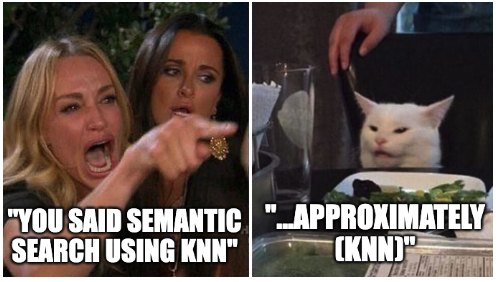

In [50]:
display(Image(filename="../images/woman-cat.png"))

Ultimately, vanilla KNN becomes infeasible for modern high-dimensional applications like embeddings, text retrieval, and image similarity search — which is why we often need to combine KNN with other techniques to *approximate* nearest neighbor

For example, you can use K-means to partition your embedding vectors into clusters, with each represented as a centroid. During semantic search, the query vectors finds it nearest centroid(s) and only searches within those clusters - dramatically reduce memory, latency, and search complexity. This technique is called IVF (Inverted File Index) and is used as an indexing technique in Vector Databases/Stores